# Deep Dream

## Add packages

In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.applications import inception_v3
import numpy as np
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) >= 1:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1. Create some helper utils

In [2]:
# https://keras.io/examples/generative/deep_dream/
# an image loader that converts a loaded image into an rbg numpy array
def preprocess_image(img_path):
    img = load_img(img_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

In [3]:
# a deprocess fumction that undoes the processing done for the inception model
def deprocess_image(img):
    # util function to convert a numpy array into an image shape
    img = img.reshape((img.shape[1], img.shape[2], 3))

    # undo inception preprocessing
    img /= 2.0
    img += 0.5
    img *= 255.

    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

## 2. Calculate the loss for each iteration of the Deep Dream Algorithm

In [4]:
def compute_loss(img, opts):
    feature_extractor = opts['feature_extractor']
    layer_settings = opts['layer_settings']

    features = feature_extractor(img)

    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), tf.float32))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    
    return loss

## 3. Create a function that computes a single pass of the Deep Dream algorithm

In [5]:
def deep_dream_step(img, opts):
    lr = opts['lr']

    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, opts)
    
    grads = tape.gradient(loss, img)
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += lr * grads
    return loss, img 


## 4. Create a function that runs the Deep Dream step for set number of loops

In [6]:
def deep_dream_loop(img, opts):
    epochs = opts['epochs']
    max_loss = opts['max_loss']

    for epoch in range(epochs):
        loss, img = deep_dream_step(img, opts)
        if max_loss is not None and loss > max_loss:
            break;
        
        if epoch % 10 == 0:
            print(" ==> loss at step {}: {:.2f}".format(epoch, loss))
    
    return img

## 5. Generate a model from layers in InceptionV3 that extract saved model features

In [7]:
def generate_feature_extractor(layer_settings):
    model = inception_v3.InceptionV3(include_top=False)

    output_dict = dict(
        [
            (layer.name, layer.output)
            for layer in [model.get_layer(name) for name in layer_settings.keys()]
        ]
    )

    feature_extractor = Model(inputs=model.inputs, outputs=output_dict)
    return feature_extractor


In [8]:
def generate_octave_shapes(original_shape, opts):
    num_octaves = opts['num_octaves']
    octave_scale = opts['octave_scale']

    octave_shapes = [original_shape]
    for octave_idx in range(1, num_octaves):
        shape = tuple([int(dim / (octave_scale ** octave_idx)) for dim in original_shape])
        octave_shapes.append(shape)
    
    octave_shapes = octave_shapes[::-1]
    return octave_shapes

## 6. Use the building blocks to generate Deep Dream effects

Processing octive 0 with shape (217, 326)
 ==&gt; loss at step 0: 0.98
 ==&gt; loss at step 10: 4.41
 ==&gt; loss at step 20: 7.49
 ==&gt; loss at step 30: 10.13
 ==&gt; loss at step 40: 12.87
Processing octive 1 with shape (304, 457)
 ==&gt; loss at step 0: 2.30
Processing octive 2 with shape (426, 640)
 ==&gt; loss at step 0: 6.42


&lt;matplotlib.image.AxesImage at 0x7fac27432910&gt;

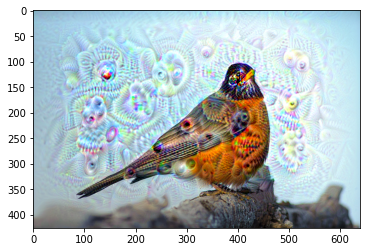

In [11]:
layer_settings = {
    "mixed3": 2.5,
    "mixed4": 0.5,
    "mixed5": 0.5,
    "mixed6": 0.5,
    "mixed7": 2.5
}
feature_extractor = generate_feature_extractor(layer_settings)

settings = {
    'lr': 0.01,
    'num_octaves': 3,
    'octave_scale': 1.4,
    'epochs': 100,
    'max_loss': 15.0,
    'layer_settings': layer_settings,
    'feature_extractor': feature_extractor
}

original_img = preprocess_image('bird.jpg')
original_shape = original_img.shape[1:3]

octive_shapes = generate_octave_shapes(original_shape, settings)
img_shrunk = tf.image.resize(original_img, octive_shapes[0])
img_copy = tf.identity(original_img)

for shape_idx, shape in enumerate(octive_shapes):
    print("Processing octive {} with shape {}".format(shape_idx, shape))
    img_copy = tf.image.resize(img_copy, shape)
    img_copy = deep_dream_loop(img_copy, settings)
    
    upscaled_img_shunk = tf.image.resize(img_shrunk, shape)
    resized_img_copy = tf.image.resize(original_img, shape)

    lost_detail = resized_img_copy - upscaled_img_shunk
    img_copy += lost_detail

    img_shrunk = tf.image.resize(original_img, shape)

img_copy = deprocess_image(img_copy.numpy())
plt.imshow(img_copy)
